# Training Models

# DistilBERT

In [22]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load data
data_distilbert = pd.read_csv("training_dataset.csv")

# Tokenize and pad sequences using DistilBERT tokenizer
tokenizer_distilbert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
maxlen_distilbert = 300

X_title_distilbert = data_distilbert['Title_tokens'].apply(lambda x: eval(x)).values
X_body_distilbert = data_distilbert['Body_tokens'].apply(lambda x: eval(x)).values
X_combined_distilbert = [' '.join(title + body) for title, body in zip(X_title_distilbert, X_body_distilbert)]

X_train_distilbert, X_test_distilbert, y_train_distilbert, y_test_distilbert = train_test_split(X_combined_distilbert, data_distilbert['LabelNum'].values, test_size=0.2, random_state=42)

# Tokenize and encode sequences
train_encodings_distilbert = tokenizer_distilbert(X_train_distilbert, truncation=True, padding=True, max_length=maxlen_distilbert)
test_encodings_distilbert = tokenizer_distilbert(X_test_distilbert, truncation=True, padding=True, max_length=maxlen_distilbert)

# Convert lists to TensorFlow Dataset
train_dataset_distilbert = tf.data.Dataset.from_tensor_slices((
    {key: np.array(value) for key, value in train_encodings_distilbert.items()},
    y_train_distilbert
)).shuffle(len(X_train_distilbert)).batch(16)

test_dataset_distilbert = tf.data.Dataset.from_tensor_slices((
    {key: np.array(value) for key, value in test_encodings_distilbert.items()},
    y_test_distilbert
)).batch(16)

# Load pre-trained DistilBERT model for sequence classification
model_distilbert = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Compile the model
optimizer_distilbert = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_distilbert = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_distilbert.compile(optimizer=optimizer_distilbert, loss=loss_distilbert, metrics=['accuracy'])

# Add early stopping to mitigate overfitting
early_stopping_distilbert = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

# Fit the model
history_distilbert = model_distilbert.fit(
    train_dataset_distilbert,
    epochs=3,
    validation_data=test_dataset_distilbert,
    callbacks=[early_stopping_distilbert]
)

# Evaluate the model
loss_distilbert, accuracy_distilbert = model_distilbert.evaluate(test_dataset_distilbert)
print("Test Accuracy (DistilBERT):", accuracy_distilbert)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
2340/2340 [==============================] - 14438s 6s/step - loss: 0.0658 - accuracy: 0.9788 - val_loss: 0.0600 - val_accuracy: 0.9804
Epoch 2/3
2340/2340 [==============================] - 14581s 6s/step - loss: 0.0370 - accuracy: 0.9877 - val_loss: 0.0468 - val_accuracy: 0.9845
Epoch 3/3
585/585 [==============================] - 1002s 2s/step - loss: 0.0519 - accuracy: 0.9856
Test Accuracy (DistilBERT): 0.9855753779411316


In [35]:
# Preprocess user input
user_input = input("Enter your text: ")
user_input_encoding = tokenizer_distilbert(user_input, truncation=True, padding=True, max_length=maxlen_distilbert, return_tensors="tf")

# Pass input to the model
predictions = model_distilbert.predict(user_input_encoding)

# Interpret model output
print("User Input: ",user_input)
print(predictions.logits[0][0])
print(predictions.logits[0][1])


if predictions.logits[0][0] > predictions.logits[0][1]:
    predicted_label_st = "Android"
    print("Predicted class:", predicted_label_st)
else:
    predicted_label_st = "IOS"
    print("Predicted class:", predicted_label_st)


1/1 [==============================] - 0s 140ms/step
User Input:  play store
3.2122428
-3.6775448
Predicted class: Android


585/585 [==============================] - 1067s 2s/step


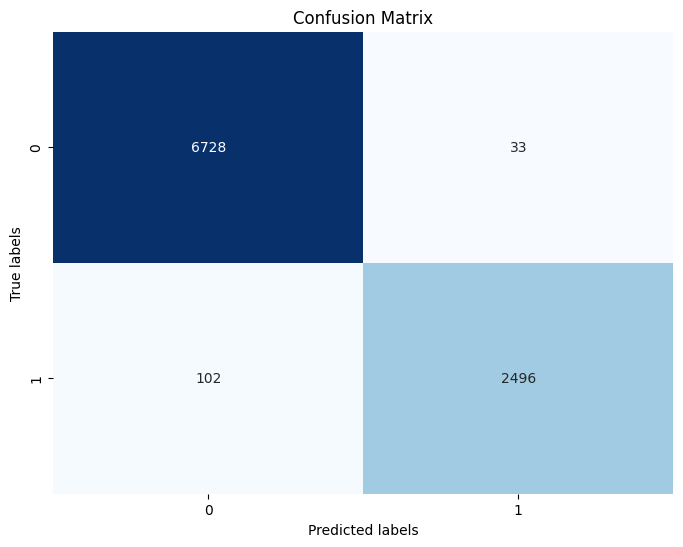

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6761
           1       0.99      0.96      0.97      2598

    accuracy                           0.99      9359
   macro avg       0.99      0.98      0.98      9359
weighted avg       0.99      0.99      0.99      9359



In [41]:
from sklearn.metrics import classification_report

# Obtain predictions on the test dataset
predictions = model_distilbert.predict(test_dataset_distilbert)

# Convert predicted probabilities/logits to class predictions (0 or 1)
y_pred_distilbert = np.argmax(predictions.logits, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_distilbert, y_pred_distilbert)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(y_test_distilbert, y_pred_distilbert))


# RoBERT

In [23]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load data
data_roberta = pd.read_csv("training_dataset.csv")

# Tokenize and pad sequences using RoBERTa tokenizer
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
maxlen_roberta = 300

X_title_roberta = data_roberta['Title_tokens'].apply(lambda x: eval(x)).values
X_body_roberta = data_roberta['Body_tokens'].apply(lambda x: eval(x)).values
X_combined_roberta = [' '.join(title + body) for title, body in zip(X_title_roberta, X_body_roberta)]

X_train_roberta, X_test_roberta, y_train_roberta, y_test_roberta = train_test_split(X_combined_roberta, data_roberta['LabelNum'].values, test_size=0.2, random_state=42)

# Tokenize and encode sequences
train_encodings_roberta = tokenizer_roberta(X_train_roberta, truncation=True, padding=True, max_length=maxlen_roberta)
test_encodings_roberta = tokenizer_roberta(X_test_roberta, truncation=True, padding=True, max_length=maxlen_roberta)

# Convert lists to TensorFlow Dataset
train_dataset_roberta = tf.data.Dataset.from_tensor_slices((
    {key: np.array(value) for key, value in train_encodings_roberta.items()},
    y_train_roberta
)).shuffle(len(X_train_roberta)).batch(16)

test_dataset_roberta = tf.data.Dataset.from_tensor_slices((
    {key: np.array(value) for key, value in test_encodings_roberta.items()},
    y_test_roberta
)).batch(16)

# Load pre-trained RoBERTa model for sequence classification
model_roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Compile the model
optimizer_roberta = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_roberta = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_roberta.compile(optimizer=optimizer_roberta, loss=loss_roberta, metrics=['accuracy'])

# Add early stopping to mitigate overfitting
early_stopping_roberta = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

# Fit the model
history_roberta = model_roberta.fit(
    train_dataset_roberta,
    epochs=1,
    validation_data=test_dataset_roberta,
    callbacks=[early_stopping_roberta]
)

# Evaluate the model
loss_roberta, accuracy_roberta = model_roberta.evaluate(test_dataset_roberta)
print("Test Accuracy (RoBERTa):", accuracy_roberta)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

585/585 [==============================] - 2127s 4s/step - loss: 0.0564 - accuracy: 0.9837
Test Accuracy (RoBERTa): 0.9836521148681641


In [43]:
# Preprocess user input
user_input = input("Enter your text: ")
user_input_encoding = tokenizer_roberta(user_input, truncation=True, padding=True, max_length=maxlen_roberta, return_tensors="tf")

# Pass input to the model
predictions = model_roberta.predict(user_input_encoding)

# Interpret model output
print("User Input: ", user_input)
print(predictions.logits[0][0])
print(predictions.logits[0][1])


if predictions.logits[0][0] > predictions.logits[0][1]:
    predicted_label_st = "Android"
    print("Predicted class:", predicted_label_st)
else:
    predicted_label_st = "IOS"
    print("Predicted class:", predicted_label_st)


1/1 [==============================] - 0s 64ms/step
User Input:  play store
1.0664793
-0.9198637
Predicted class: Android


585/585 [==============================] - 2221s 4s/step


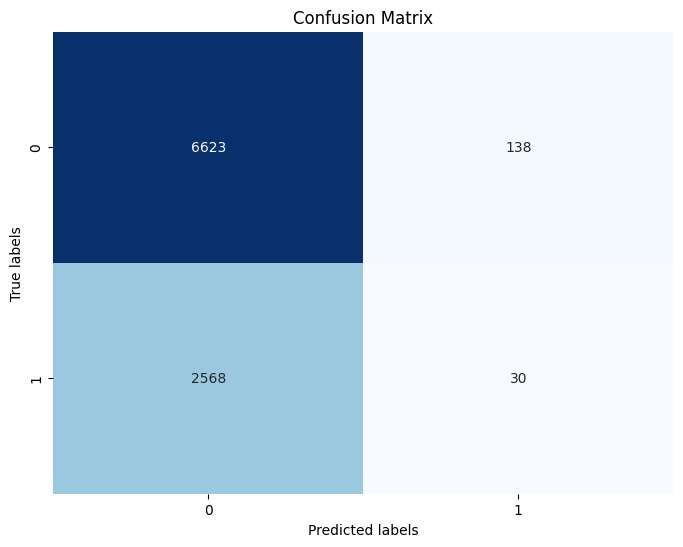

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      6761
           1       0.18      0.01      0.02      2598

    accuracy                           0.71      9359
   macro avg       0.45      0.50      0.43      9359
weighted avg       0.57      0.71      0.61      9359



In [44]:
from sklearn.metrics import classification_report

# Obtain predictions on the test dataset
predictions = model_roberta.predict(test_dataset_distilbert)

# Convert predicted probabilities/logits to class predictions (0 or 1)
y_pred_roberta = np.argmax(predictions.logits, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_roberta, y_pred_roberta)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(y_test_roberta, y_pred_roberta))
